In [1]:
from kan import *
import torch
from kan.utils import create_dataset
import matplotlib.pyplot as plt

device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

### CREATE A kan KAN

In [2]:
kan = KAN([2,3,1], device=device, grid = 3, k = 3, seed = 2)

checkpoint directory created: ./model
saving model version 0.0


### CREATE A DATASET FROM FUNCTION DEFINED AS BELOW

In [3]:
#create dataset
#f(x,y) = e^(sin(pi*x)+y^2) + noise
f = lambda x : torch.exp(torch.cos(torch.pi * x[:, [0]]) + x[:, [1]]**2) + torch.randn_like(x[:,[1]])*0.1
dataset = create_dataset(f, n_var=2, device = device, train_num = 1000, test_num = 800)

train = dataset['train_input']
train_target = dataset['train_label']
print(train.shape)
print(train_target.shape)

torch.Size([1000, 2])
torch.Size([1000, 1])


### LET THE kan SEE THE DATA AND PLOT THE INITIAL kan


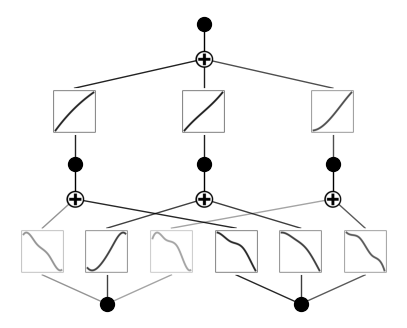

In [4]:
kan(dataset['train_input'])
kan.plot()

### TRAIN WITH L1 REGULARIZATION FOR LATER SPARSIFICATION
#### L1 norm of an activation function $\phi$ over its $N_p$ input : $$|\phi|_1 = \frac{1}{N_p} \times \sum_{s=1}^{N_p}{\phi (x_s)} $$
#### For a KAN layer $ \ Phi $ with $n_{in}$ inputs and $n_{out}$ outputs, L1 norm of the layer is the sum of L1 norms of all activation function in that layer : $$|\Phi|_1 = \sum_{i=1}^{n_{in}}{\sum_{j=1}^{n_{j}}{|\phi_{i,j}|_1}} $$
#### Entropy of KAN Layer $\Phi$ : $$ S(\Phi) = \sum_{i=1}^{n_{in}}{\sum_{j=1}^{n_{j}}}{\frac{|\phi_{i,j}|_1}{|\Phi|_1} \times log(\frac{|\phi_{i,j}|_1}{|\Phi|_1})} $$

#### Total loss of KAN with L layers : $$l_{total} = l_{pred} + \lambda \times (\lambda_1 \sum_{l=0}^{L-1}{|\Phi|_1} +\lambda_2 \sum_{l=0}^{L-1}{S(\Phi_l)}) $$

| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.74e+01 | : 100%|█| 30/30 [00:17<00:00,  1.74it


saving model version 0.1


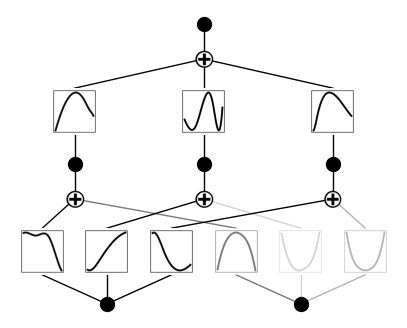

In [5]:
kan.fit(dataset, opt="LBFGS", steps=40, lamb=0.01, lamb_l1=10., lamb_entropy=10.)
kan.plot()

### PRUNING (SPARSIFICATION)
##### For a node of layer $l^{th}$ , $i^{th}$ neuron : 
##### $$ I_{l,i} = max_k(|\phi_{l-1, i, k}|1)$$ 
##### $$ O_{l,i} = max_j(|\phi_{l+1, i, j}|1)$$
##### A node is considered "important" if both score are greater than a threshold $\theta$ (set = 0.01)

saving model version 0.2


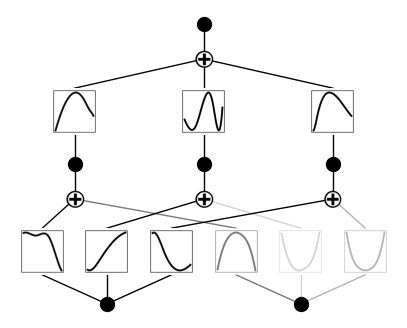

In [6]:
kan = kan.prune(node_th=0.01)
kan.plot()

### CONTINUE TRAINING ON SPARSIFIED KAN (AND EXTEND GRID)

| train_loss: 9.95e-02 | test_loss: 1.01e-01 | reg: 2.27e+01 | : 100%|█| 10/10 [00:04<00:00,  2.13it


saving model version 0.3
saving model version 0.4


| train_loss: 9.43e-02 | test_loss: 1.01e-01 | reg: 2.30e+01 | : 100%|█| 10/10 [00:04<00:00,  2.08it


saving model version 0.5


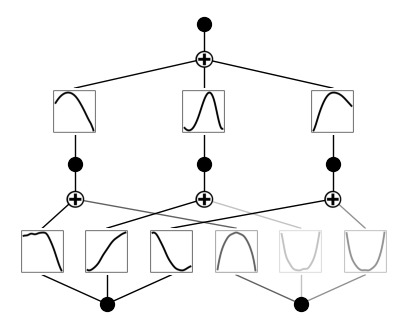

In [7]:
kan.fit(dataset, opt= "LBFGS", steps = 10)
kan = kan.refine(10)    
kan.fit(dataset, opt="LBFGS", steps=10)
kan.plot()

### SET ACTIVATION FUNCTIONS (SPLINES -> SYMBOLIC)

In [8]:
mode = "auto" # "manual"
from kan.utils import SYMBOLIC_LIB
if mode == "manual":
    # manual mode
    kan.fix_symbolic(0,0,0,'sin')
    kan.fix_symbolic(0,1,0,'x^2')
    kan.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    kan.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.6049546003341675, c=1
fixing (0,0,1) with x, r2=0.982212483882904, c=1
fixing (0,0,2) with sin, r2=0.9971287846565247, c=2
fixing (0,1,0) with x^2, r2=0.9823001027107239, c=2
fixing (0,1,1) with x^2, r2=0.9567480087280273, c=2
fixing (0,1,2) with x^2, r2=0.9611103534698486, c=2
fixing (1,0,0) with sin, r2=0.9995449781417847, c=2
fixing (1,1,0) with sin, r2=0.9754253625869751, c=2
fixing (1,2,0) with sin, r2=0.9935716390609741, c=2
saving model version 0.6


### CONTINUE TRAINING 

In [9]:

#kan.fit(dataset, opt="LBFGS", steps=15)

### OPTAIN SYMBOLIC 

In [10]:
from kan.utils import ex_round
ex_round(kan.symbolic_formula()[0][0],4)

2.5997*sin(0.8633*x_1 + 0.6794*(-x_2 - 0.0028)**2 + 0.1385) + 3.2493*sin(3.7219*x_1 + 0.3778*(-x_2 - 0.0043)**2 + 0.632) + 44.9142*sin(0.0956*(-x_2 - 0.0005)**2 + 0.4616*sin(1.7123*x_1 - 8.7578) + 1.482) - 40.3032